In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from tqdm import tqdm  # For progress bars
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit
import numpy as np
import pickle
from tqdm import tqdm
import numpy as np
import pickle
from tqdm import tqdm
from numba import njit
from joblib import Parallel, delayed

# Set random seed for reproducibility
np.random.seed(42)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [3]:
def meanfield_simulation(N, K, T, B, return_full_history=False):
    """
    Simulates the delay evolution in a Mean Field (MF) approximation.
    
    Parameters:
    - N (int): Number of nodes (system components).
    - K (int): Number of inputs/neighbors per node.
    - T (int): Number of time steps.
    - B (float): Buffer size.
    - return_full_history (bool): If True, returns (N, T) matrix. 
                                  If False, returns (T,) vector of mean delays (memory efficient).
    
    Returns:
    - delays: Array of delays.
    """
    # Initialize state: Delays at t=0 are just the noise
    current_tau = np.random.exponential(scale=1.0, size=N)
    
    if return_full_history:
        history = np.zeros((N, T))
        history[:, 0] = current_tau
    else:
        # If we only need the mean delay per time step (for plots c and d)
        history = np.zeros(T)
        history[0] = np.mean(current_tau)

    # Simulation loop
    for t in range(1, T):
        # 1. Select random neighbors for all N nodes (MF assumption: reshuffled every step)
        # Shape: (N, K)
        neighbor_indices = np.random.randint(0, N, size=(N, K))
        
        # 2. Retrieve the delays of these neighbors from the previous step
        # Shape: (N, K)
        neighbor_delays = current_tau[neighbor_indices]
        
        # 3. Calculate the maximum delay among neighbors
        # Shape: (N,)
        max_neighbor_delay = np.max(neighbor_delays, axis=1)
        
        # 4. Apply Buffer B and Rectification (ReLU)
        # "positive_part" from Julia code
        buffered_delay = np.maximum(0, max_neighbor_delay - B)
        
        # 5. Add new intrinsic noise (epsilon)
        epsilon = np.random.exponential(scale=1.0, size=N)
        current_tau = buffered_delay + epsilon
        
        # Store results
        if return_full_history:
            history[:, t] = current_tau
        else:
            history[t] = np.mean(current_tau)
            
    return history

def get_order_parameter(mean_delays_series):
    """
    Calculates the order parameter v (velocity of delay growth).
    This corresponds to the slope of the mean delay vs time.
    
    We simply take the mean difference, equivalent to the slope 
    averaged over the simulation.
    """
    # Exclude the transient initial phase (first 10% of simulation)
    start_idx = int(len(mean_delays_series) * 0.1)
    return np.mean(np.diff(mean_delays_series[start_idx:]))

Running Phase Transition Sweep...


100%|██████████| 200/200 [03:39<00:00,  1.10s/it]


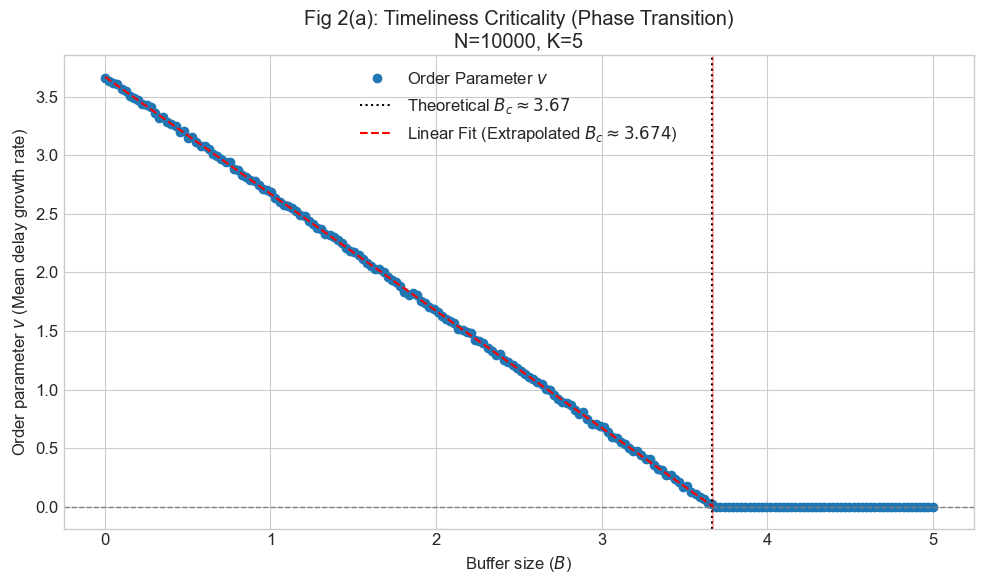

In [6]:
# Simulation Parameters
N = 10000     # Reduced slightly from 10k for speed, qualitative result is same
K = 5        # Number of neighbors
T = 2000     # Time steps
B_values = np.linspace(0, 5.0, 200) # Range of Buffers to test

velocities = []

print("Running Phase Transition Sweep...")
for B in tqdm(B_values):
    # Run simulation
    mean_delays = meanfield_simulation(N, K, T, B)
    
    # Calculate order parameter v (velocity)
    v = get_order_parameter(mean_delays)
    velocities.append(v)

# --- Calculate Critical Transition via Linear Fit ---
# Filter for the linear regime (where velocity is significantly above zero)
v_arr = np.array(velocities)
mask = v_arr > 0.05  # Adjust threshold if necessary
if np.any(mask):
    slope, intercept, r_value, p_value, std_err = linregress(B_values[mask], v_arr[mask])
    calculated_Bc = -intercept / slope
else:
    calculated_Bc = None

# --- Plotting Figure 2(a) ---
plt.figure(figsize=(10, 6))
plt.plot(B_values, velocities, 'o', markersize=6, color='#1f77b4', label='Order Parameter $v$')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Theoretical B_c
Bc_approx = 3.67
plt.axvline(Bc_approx, color='black', linestyle=':', label=f'Theoretical $B_c \\approx {Bc_approx}$')

# Plot Calculated Fit
if calculated_Bc:
    fit_x = np.linspace(B_values[mask][0], calculated_Bc, 50)
    plt.plot(fit_x, slope * fit_x + intercept, color='red', linestyle='--', 
             label=f'Linear Fit (Extrapolated $B_c \\approx {calculated_Bc:.3f}$)')
    plt.axvline(calculated_Bc, color='red', alpha=0.3)

plt.title(f'Fig 2(a): Timeliness Criticality (Phase Transition)\nN={N}, K={K}')
plt.xlabel('Buffer size ($B$)')
plt.ylabel('Order parameter $v$ (Mean delay growth rate)')
plt.legend()
plt.tight_layout()
plt.show()

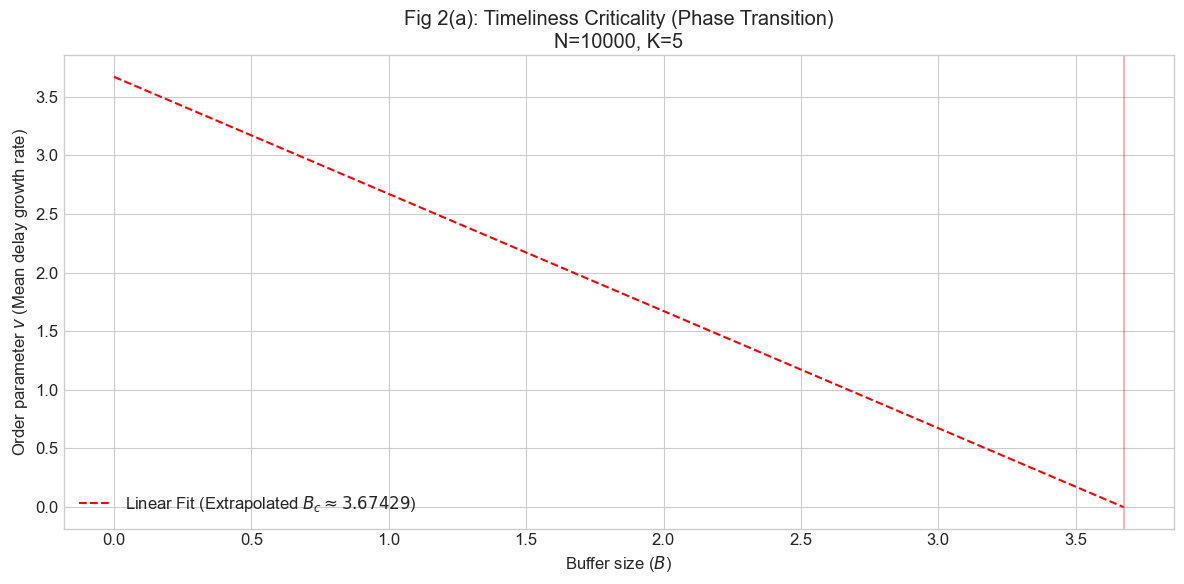

In [7]:
# Plot Calculated Fit
if calculated_Bc:
    fit_x = np.linspace(B_values[mask][0], calculated_Bc, 50)
    plt.plot(fit_x, slope * fit_x + intercept, color='red', linestyle='--', 
             label=f'Linear Fit (Extrapolated $B_c \\approx {calculated_Bc:.5f}$)')
    plt.axvline(calculated_Bc, color='red', alpha=0.3)

plt.title(f'Fig 2(a): Timeliness Criticality (Phase Transition)\nN={N}, K={K}')
plt.xlabel('Buffer size ($B$)')
plt.ylabel('Order parameter $v$ (Mean delay growth rate)')
plt.legend()
plt.tight_layout()
plt.show()

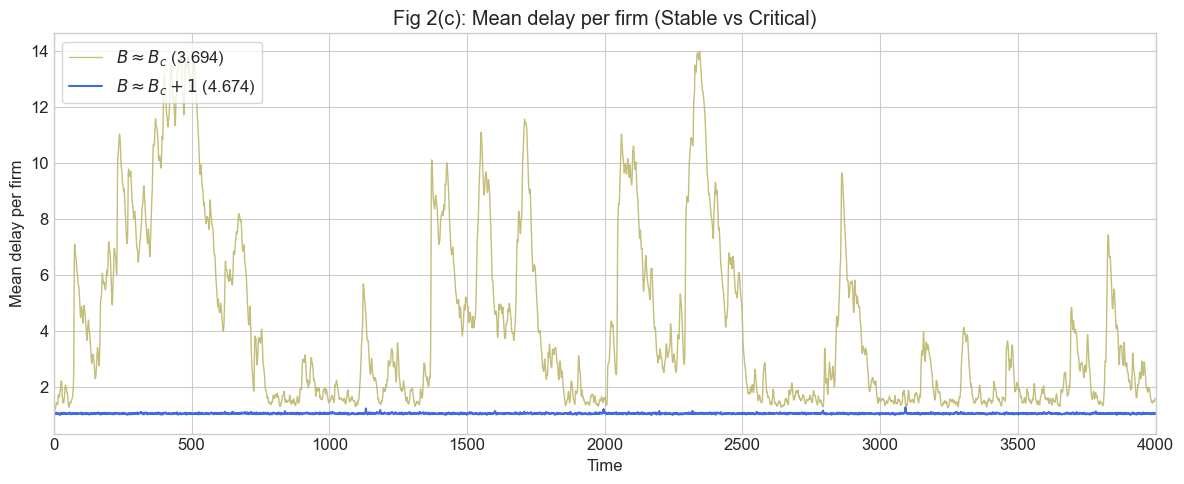

In [ ]:
# Parameters matching the paper's context
N = 10000
K = 5
T = 4000
Bc = 3.67429  # Critical buffer value

# Case 1: Close to criticality (from above)
B_critical = Bc + 0.02 
mean_delays_crit = meanfield_simulation(N, K, T, B_critical)

# Case 2: Safely stable
B_stable = Bc + 1.0
mean_delays_stable = meanfield_simulation(N, K, T, B_stable)

# --- Plotting Figure 2(c) ---
plt.figure(figsize=(12, 5))

plt.plot(mean_delays_crit, color='#bdb76b', linewidth=1, alpha=0.9, label=f'$B \\approx B_c$ ({B_critical:.3f})')
plt.plot(mean_delays_stable, color='#4169e1', linewidth=1.5, label=f'$B \\approx B_c + 1$ ({B_stable:.3f})')

plt.title('Fig 2(c): Mean delay per firm (Stable vs Critical)')
plt.xlabel('Time')
plt.ylabel('Mean delay per firm')
plt.legend(loc='upper left', frameon=True)
plt.xlim(0, T)
plt.tight_layout()
plt.show()

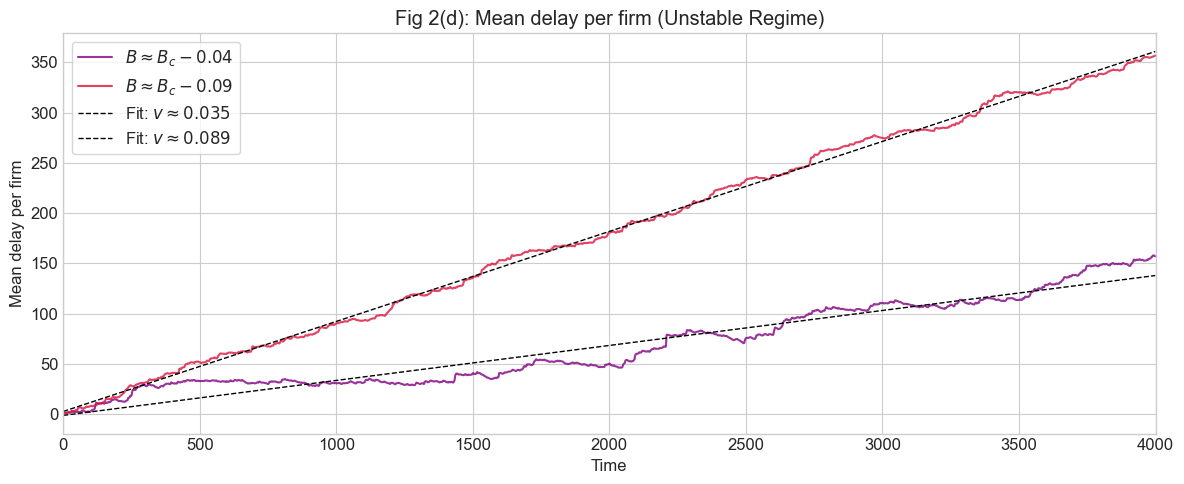

In [13]:
# Parameters
N = 10000
K = 5
T = 4000

# Case 1: Slightly unstable
B_unstable_1 = Bc - 0.04
mean_delays_u1 = meanfield_simulation(N, K, T, B_unstable_1)

# Case 2: More unstable
B_unstable_2 = Bc - 0.09
mean_delays_u2 = meanfield_simulation(N, K, T, B_unstable_2)

# Fit lines to get the exact slope (velocity v)
slope1, intercept1, _, _, _ = linregress(np.arange(T), mean_delays_u1)
slope2, intercept2, _, _, _ = linregress(np.arange(T), mean_delays_u2)

# --- Plotting Figure 2(d) ---
plt.figure(figsize=(12, 5))

# Plot Data
plt.plot(mean_delays_u1, color='#800080', linewidth=1.5, alpha=0.8, 
         label=f'$B \\approx B_c - 0.04$')
plt.plot(mean_delays_u2, color='#dc143c', linewidth=1.5, alpha=0.8, 
         label=f'$B \\approx B_c - 0.09$')

# Plot Fits
t_vals = np.arange(T)
plt.plot(t_vals, slope1 * t_vals + intercept1, color='black', linestyle='--', linewidth=1,
         label=f'Fit: $v \\approx {slope1:.3f}$')
plt.plot(t_vals, slope2 * t_vals + intercept2, color='black', linestyle='--', linewidth=1,
         label=f'Fit: $v \\approx {slope2:.3f}$')

plt.title('Fig 2(d): Mean delay per firm (Unstable Regime)')
plt.xlabel('Time')
plt.ylabel('Mean delay per firm')
plt.legend(loc='upper left', frameon=True)
plt.xlim(0, T)
plt.tight_layout()
plt.show()

In [8]:
# --- Configuration ---
N = 10000          
K = 5              
T = 500000          
TRIALS = 5        
B_list = [3.7095, 3.6967, 3.6882, 3.6825, 3.6787]

# --- FIX 1: Explicit Seeding ---
# We pass a unique 'seed' to the JIT function to ensure
# parallel workers are mathematically independent.
@njit(fastmath=True)
def run_simulation_numba(N, K, T, B, seed):
    np.random.seed(seed)
    
    # OPTIMIZATION: Double Buffering
    # Instead of updating in-place or using a temporary max_prev array (which requires 2 loops),
    # we bounce between two rows of a matrix.
    # [0, :] = current step, [1, :] = next step
    delays = np.zeros((2, N))
    delays[0] = np.random.exponential(1.0, N)
    
    mean_delay_history = np.zeros(T)
    
    # Pointers to current (read) and next (write) buffers
    curr_ptr = 0
    next_ptr = 1
    
    for t in range(T):
        scalar_sum = 0.0
        
        # Single loop over N: Find neighbors AND update
        for i in range(N):
            # 1. Neighbor Selection (reading from curr_ptr)
            # Unrolled first iter for speed
            idx = np.random.randint(0, N)
            max_d = delays[curr_ptr, idx]
            
            # Check remaining K-1 neighbors
            for k in range(K - 1):
                idx = np.random.randint(0, N)
                val = delays[curr_ptr, idx]
                if val > max_d:
                    max_d = val
            
            # 2. Update Rule (writing to next_ptr)
            # ReLU(max - B) + noise
            val = max_d - B
            if val < 0.0:
                val = 0.0
            
            noise = np.random.exponential(1.0)
            new_val = val + noise
            
            delays[next_ptr, i] = new_val
            scalar_sum += new_val
        
        mean_delay_history[t] = scalar_sum / N
        
        # Swap pointers for next step
        curr_ptr = 1 - curr_ptr
        next_ptr = 1 - next_ptr
        
    return mean_delay_history


# --- Worker Function ---
def process_trial(B, N, K, T, seed):
    # Pass the seed down
    full_series = run_simulation_numba(N, K, T, B, seed)
    
    # Burn-in: Discard first 5% to ensure we are in steady state
    # This validates the Ergodicity assumption.
    series = full_series[int(0.05*T):]
    
    # 1. Autocorrelation 
    fluc = series - np.mean(series)
    n = len(fluc)
    # FFT is efficient enough for 5M points (O(N log N))
    f = np.fft.fft(fluc, n=2*n)
    acf_raw = np.fft.ifft(f * np.conjugate(f))[:n].real
    
    # Truncate to save RAM (we only care about the decay tail)
    limit = min(len(acf_raw), 100000)
    acf_norm = acf_raw[:limit] / acf_raw[0]
    
    # 2. Avalanche Statistics
    is_avalanche = series > B
    durations = []
    sizes = []
    
    if np.any(is_avalanche):
        # Fast state change detection
        # Prepending/appending False ensures we capture start/end at boundaries
        diffs = np.diff(np.concatenate(([False], is_avalanche, [False])).astype(int))
        starts = np.where(diffs == 1)[0]
        ends = np.where(diffs == -1)[0]
        durations = ends - starts
        
        # Vectorized size calculation is hard with variable lengths, 
        # but a simple loop is negligible compared to simulation time.
        for s, e in zip(starts, ends):
            sizes.append(np.sum(series[s:e] - B))
            
    return B, acf_norm, durations, sizes

# --- Execution ---
if __name__ == "__main__":
    # Create valid task list with UNIQUE SEEDS
    # Enumerate provides a unique integer index for every single task
    tasks = [(B, i) for i, B in enumerate(B_list * TRIALS)]

    print(f"Starting Parallel Simulation: N={N}, T={T}, Total Tasks={len(tasks)}")

    results_gen = Parallel(n_jobs=-1, return_as='generator')(
        delayed(process_trial)(B, N, K, T, seed) for B, seed in tasks
    )

    sim_results = {b: {'acfs': [], 'durations': [], 'sizes': []} for b in B_list}

    for B, acf, durs, szs in tqdm(results_gen, total=len(tasks)):
        sim_results[B]['acfs'].append(acf)
        sim_results[B]['durations'].extend(durs)
        sim_results[B]['sizes'].extend(szs)

    final_store = {}
    for B in B_list:
        if len(sim_results[B]['acfs']) > 0:
            final_store[B] = {
                'avg_acf': np.mean(np.array(sim_results[B]['acfs']), axis=0),
                'durations': np.array(sim_results[B]['durations']),
                'sizes': np.array(sim_results[B]['sizes'])
            }

    with open('timeliness_data_long.pkl', 'wb') as f:
        pickle.dump(final_store, f)
    print("Done.")

Starting Parallel Simulation: N=10000, T=500000, Total Tasks=25


100%|██████████| 25/25 [16:25<00:00, 39.43s/it]  

Done.


Extracting characteristic times (integral method)...
  B=3.7095: tau=223.8
  B=3.6967: tau=405.6
  B=3.6882: tau=1360.8
  B=3.6825: tau=4085.9
  B=3.6787: tau=6096.0

Fitted Bc: 3.6643, Gamma: 3.0000
  B=3.7095: scale_factor=0.04
  B=3.6967: scale_factor=0.07
  B=3.6882: scale_factor=0.22
  B=3.6825: scale_factor=0.67
  B=3.6787: scale_factor=1.00


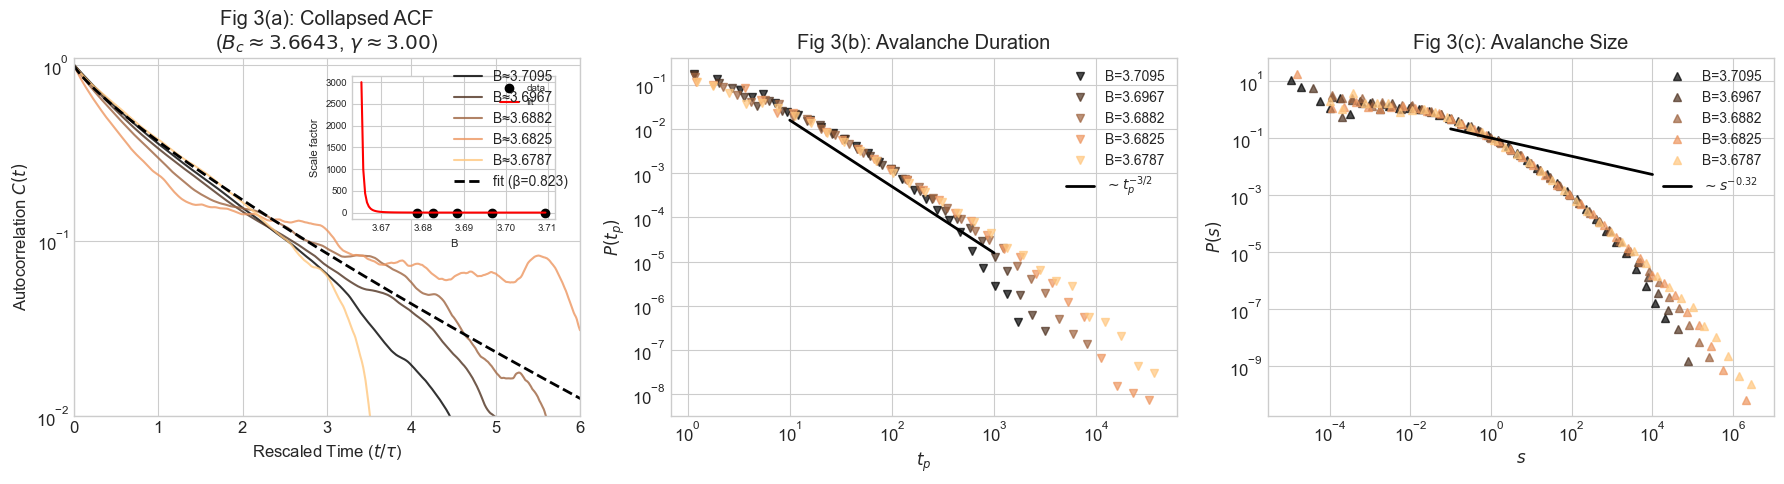

In [14]:
# --- Load Data ---
with open('timeliness_data_long.pkl', 'rb') as f:
    data_store = pickle.load(f)

B_list = sorted(data_store.keys(), reverse=True)  # Largest B first
B_ref_val = B_list[-1]  # Reference: Smallest B (closest to critical)

# --- 1. Extract characteristic time using integral method ---
# More robust than fitting - just integrate ACF to get correlation time
print("Extracting characteristic times (integral method)...")

tau_values = {}
for B in B_list:
    acf = data_store[B]['avg_acf']
    # Integrate ACF up to where it's still positive and above noise
    valid = acf > 0.01
    if np.any(~valid):
        cutoff = np.argmax(~valid)
    else:
        cutoff = len(acf)
    tau_values[B] = np.sum(acf[:cutoff])  # Integral = correlation time
    print(f"  B={B:.4f}: tau={tau_values[B]:.1f}")

# --- 2. Fit Bc and gamma ---
# tau diverges as (B - Bc)^(-gamma), so we fit this
tau_arr = np.array([tau_values[b] for b in B_list])
B_vals = np.array(B_list)

def fit_divergence(params):
    Bc, gamma = params
    if Bc >= min(B_vals):
        return 1e10
    predicted = (B_vals - Bc)**(-gamma)
    # Normalize to match scale
    predicted = predicted / predicted[-1] * tau_arr[-1]
    return np.sum((np.log(predicted) - np.log(tau_arr))**2)

result = minimize(fit_divergence, [3.67, 1.7], bounds=[(3.0, 3.678), (0.5, 3.0)])
my_Bc, my_gamma = result.x
print(f"\nFitted Bc: {my_Bc:.4f}, Gamma: {my_gamma:.4f}")

# --- 3. Calculate scale factors ---
# Scale factor = tau_B / tau_ref = how much to COMPRESS time for curve B
# to match reference curve
# Equivalently: rescaled_time = t / tau_B * tau_ref = t / scale_factor
scale_factors = {}
tau_ref = tau_values[B_ref_val]
for B in B_list:
    scale_factors[B] = tau_values[B] / tau_ref
    print(f"  B={B:.4f}: scale_factor={scale_factors[B]:.2f}")

# --- 4. Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot A: Collapsed ACF
ax = axes[0]
colors = plt.cm.copper(np.linspace(0, 1, len(B_list)))

for i, B in enumerate(B_list):
    acf = data_store[B]['avg_acf']
    tau = tau_values[B]
    
    # Truncate at noise floor
    valid_mask = acf > 0.005
    if np.any(~valid_mask):
        cutoff = np.argmax(~valid_mask)
    else:
        cutoff = len(acf)
    cutoff = min(cutoff, 50000)
    
    t = np.arange(cutoff)
    # Rescale: divide by tau to normalize all curves
    ax.plot(t / tau, acf[:cutoff], color=colors[i], label=f'B≈{B:.4f}', alpha=0.8, linewidth=1.5)

# Add stretched exponential fit on normalized scale
t_fit = np.linspace(0.001, 8, 500)
beta_fit = 0.823
ax.plot(t_fit, np.exp(-t_fit**beta_fit), 'k--', linewidth=2, label=f'fit (β={beta_fit})')

ax.set_yscale('log')
ax.set_xlim(0, 6)
ax.set_ylim(1e-2, 1.1)
ax.set_title(f"Fig 3(a): Collapsed ACF\n($B_c\\approx{my_Bc:.4f}$, $\\gamma\\approx{my_gamma:.2f}$)")
ax.set_xlabel(r"Rescaled Time ($t / \tau$)")
ax.set_ylabel("Autocorrelation $C(t)$")
ax.legend(fontsize='small', loc='upper right')

# Inset: Scale factor vs B
ax_inset = ax.inset_axes([0.55, 0.55, 0.4, 0.4])
ax_inset.plot(B_vals, [scale_factors[b] for b in B_list], 'ko', markersize=6, label='data')
B_fit = np.linspace(my_Bc + 0.001, max(B_vals), 100)
# scale_factor ~ tau ~ (B - Bc)^(-gamma)
scale_fit = ((B_fit - my_Bc) / (B_ref_val - my_Bc))**(-my_gamma)
ax_inset.plot(B_fit, scale_fit, 'r-', linewidth=1.5, label='fit')
ax_inset.set_xlabel('B', fontsize=8)
ax_inset.set_ylabel('Scale factor', fontsize=8)
ax_inset.tick_params(labelsize=7)
ax_inset.legend(fontsize=7)

# Plot B: Avalanche Duration
ax = axes[1]
for i, B in enumerate(B_list):
    durs = data_store[B]['durations']
    if len(durs) == 0:
        continue
    
    bins = np.logspace(0, np.log10(max(durs)), 30)
    hist, _ = np.histogram(durs, bins=bins, density=True)
    centers = (bins[:-1] + bins[1:]) / 2
    
    mask = hist > 0
    ax.loglog(centers[mask], hist[mask], 'v', color=colors[i], alpha=0.7, label=f'B={B:.4f}')

x_guide = np.logspace(1, 3, 10)
y_guide = 0.5 * x_guide**(-1.5)
ax.loglog(x_guide, y_guide, 'k-', linewidth=2, label=r'$\sim t_p^{-3/2}$')
ax.set_title("Fig 3(b): Avalanche Duration")
ax.set_xlabel("$t_p$")
ax.set_ylabel("$P(t_p)$")
ax.legend(fontsize='small')

# Plot C: Avalanche Size
ax = axes[2]
for i, B in enumerate(B_list):
    sizes = data_store[B]['sizes']
    if len(sizes) == 0:
        continue
    
    bins = np.logspace(np.log10(max(min(sizes), 1e-6)), np.log10(max(sizes)), 40)
    hist, _ = np.histogram(sizes, bins=bins, density=True)
    centers = (bins[:-1] + bins[1:]) / 2
    
    mask = hist > 0
    ax.loglog(centers[mask], hist[mask], '^', color=colors[i], alpha=0.7, label=f'B={B:.4f}')

x_guide = np.logspace(-1, 4, 20)
y_guide = 0.1 * x_guide**(-0.32)
ax.loglog(x_guide, y_guide, 'k-', linewidth=2, label=r'$\sim s^{-0.32}$')

ax.set_title("Fig 3(c): Avalanche Size")
ax.set_xlabel("$s$")
ax.set_ylabel("$P(s)$")
ax.legend(fontsize='small')

plt.tight_layout()
plt.show()